In [26]:
import pickle
from pathlib import Path
from easydict import EasyDict
import pandas as pd
from matplotlib import pyplot as plt
from ml import train
from dataloading import get_data, build_features, DataParser, MovingWindow
from tabulate import tabulate
from IPython.display import clear_output
import numpy as np

%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
cfgs, btests = [], []
for p in sorted(Path("optimization").glob("*.pickle")):
    cfg, btest = pickle.load(open(p, "rb"))
    cfgs.append(cfg)
    btests.append(btest)
print(len(btests))

fsize = 64
tfdict = {"M5":0, "M15":1, "H1":2}
X, y, poslist = [], [], []
for btest in btests:
    # print(btest.cfg.ticker, end=" ")
    hist_pd, hist = DataParser(btest.cfg).load()
    mw = MovingWindow(hist, fsize+2)
    # print(len(btest.positions))
    for pos in btest.positions[4:]:
        f, _ = mw(pos.open_indx)
        x = build_features(f, 
                           pos.dir, 
                           btest.cfg.stops_processor.func.cfg.sl, 
                           btest.cfg.trailing_stop_rate,
                           pos.open_date, 
                           tfdict[btest.cfg.period])
        X.append([x])
        y.append(pos.profit)
        poslist.append(pos)
        
X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)
print(X.shape, y.shape)
print(f"{X[0, 0, -2, 0]:8.0f} -> {X[-1, 0, -2, 0]:8.0f}")

24
(9792, 1, 9, 64) (9792,)
20170822 -> 20201230


In [28]:
def smooth_bin_labels(y, dp=0.3):
    y = y.astype(np.float32)
    d = np.random.uniform(0, dp, sum(y[:, 0]==0))
    y[y[:, 0]==0, 0] = d
    y[y[:, 1]==1, 1] = 1-d
    return y

def smooth_prob_labels(y, dp=0.1):
    y = y.astype(float)
    d = np.random.uniform(-dp, dp, sum(y[:, 0]==0))
    y += dp
    return y

def stohastic_prediction(input_tensor):
    pmeans, pstds, ymeans = np.zeros((3, input_tensor.shape[0]))
    for i, x in enumerate(input_tensor):
        p = model(torch.stack([x]*100)).detach().cpu().numpy()[:, 0]
        pmeans[i] = p.mean()
        pstds[i] = p.std()
    return pmeans, pstds

def calc_weights(predicts, th):
    p = (predicts > th).astype(np.float32)
    return p
    #return np.clip((predicts+th)**30, 0, 1)
    
def calc_weights2(predicts, th):
    p = (predicts>th).sum(axis=0)/predicts.shape[0] >= 0.2
    #p = np.median(predicts, axis=0) > th
    return p

[001,    19] loss train: 129.4463 | test: 4.8885
  iter     prof    gprof    pboost    pboost mean    pboost median    pboost std    model_fails, %    threshold
------  -------  -------  --------  -------------  ---------------  ------------  ----------------  -----------
     0  594.114  427.319   39.0327        39.0327          39.0327             0                 0     0.483581



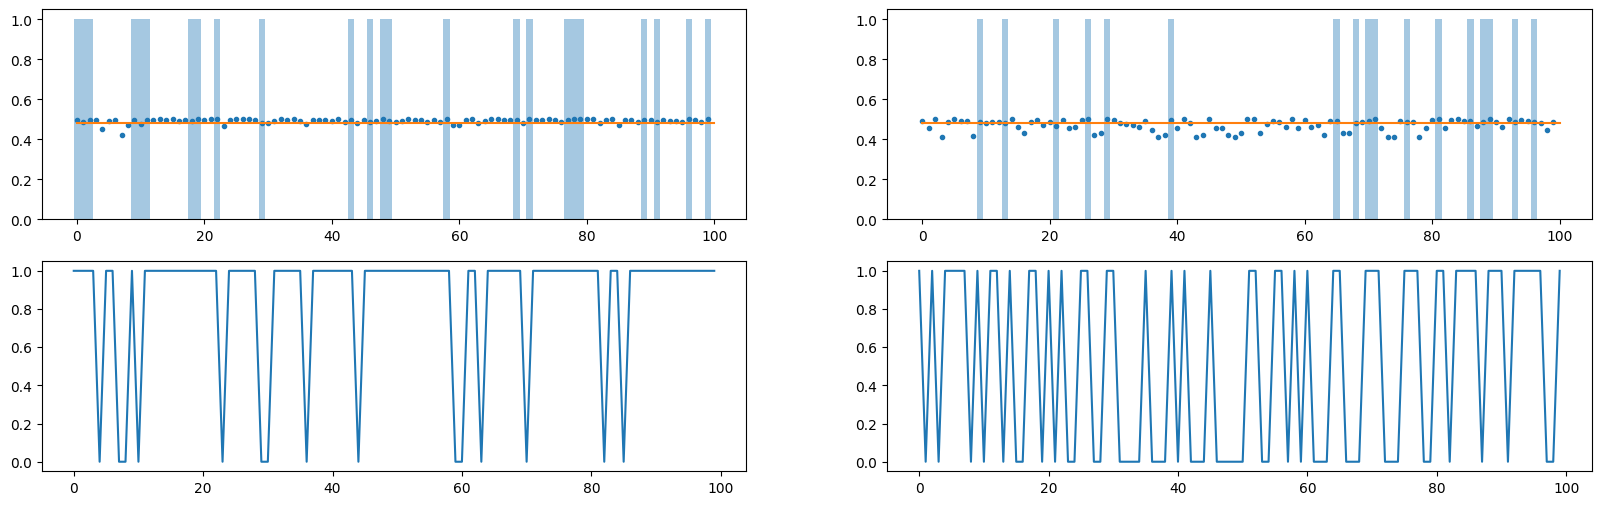

In [55]:
import torch
device = "cuda"

nitrers = 1
test_split_size = 0.02
calc_test = True
id2tf = {v:k for k, v in tfdict.items()}

pprofits, gprofits, metrics, table = np.zeros((3, nitrers)), np.zeros((3, nitrers)), np.zeros((2, nitrers)), []
for i in range(nitrers):
    if i >= 0:
        np.random.seed(i)
        X_train, X_test, y_train, y_test, profs_train, profs_test, tf_test = get_data(X, y, test_split_size)
    X_train = torch.tensor(X_train).float().to(device)
    X_test = torch.tensor(X_test).float().to(device)
    model = train(X_train, y_train, X_test, y_test, batch_size=512, epochs=1, device=device, calc_test=calc_test)
    model.eval()
    p_test = model(X_test).detach().cpu().numpy().squeeze()[:, 0]
    p_train = model(X_train).detach().cpu().numpy().squeeze()[:, 0]    
    
    p_test = np.expand_dims(p_test, 0)
    # for m in range(9):
    #     np.random.seed(m+100)
    #     train_ids = np.random.choice(np.arange(y_train.shape[0]), int(y_train.shape[0]*0.7))
    #     model = train(X_train[train_ids], y_train[train_ids], X_test, y_test, batch_size=512, device=device, calc_test=False)
    #     model.eval()
    #     p_test_ = model(X_test).detach().cpu().numpy().squeeze()[:, 0]
    #     p_test = np.vstack([p_test, p_test_])
        
    profsum_best, threshold = -999999, np.percentile(p_train, 20)
    # for th in np.arange(0., 0.9, 0.025):
    #     w_profs_train = calc_weights(p_train, th)
    #     profsum = (profs_train*w_profs_train).sum()
    #     if profsum > profsum_best:
    #         profsum_best = profsum
    #         threshold = th

    w_profs_train = calc_weights(p_train, threshold)
    
    if test_split_size > 0:
        w_profs_test = calc_weights(p_test[0], threshold)
        for j in range(3):
            ids = tf_test == j
            pprofits[j, i] = (profs_test[ids]*w_profs_test[ids]).sum()
            gprofits[j, i] = profs_test[ids].sum()
        
        pprofs_sum = np.nansum(pprofits[:, :i+1], 0) 
        gprofs_sum = np.nansum(gprofits[:, :i+1], 0)
        profs_ratio = (pprofs_sum - gprofs_sum)/abs(gprofs_sum)*100
        curprof_ratio = (pprofs_sum[-1] - gprofs_sum[-1])/abs(gprofs_sum[-1])*100
        model_fails = np.nansum(profs_ratio < 0)/(i+1)
        prof_boost_mean = np.nanmean(profs_ratio)
        prof_boost_median = np.nanmedian(profs_ratio)
        prof_boost_std = np.nanstd(profs_ratio)
        if i > 0:
            clear_output(wait=True)
        table.append([i, pprofs_sum[-1], gprofs_sum[-1], curprof_ratio, 
                      prof_boost_mean, prof_boost_median, prof_boost_std, model_fails*100, threshold])
        print(tabulate(table, headers=["iter", "prof", "gprof", "pboost", "pboost mean", "pboost median", "pboost std", "model_fails, %", "threshold"]))
        print()
        
plt.figure(figsize=(20, 6))
plt.subplot(2, 2, 1)
plt.plot(p_train[:100], ".")
plt.bar(np.arange(100), y_train[:100, 0], width=[1]*100, alpha=0.4)
plt.plot([0, 100], [threshold, threshold])
if len(p_test):
    p_test4show = np.median(p_test, axis=0)
    plt.subplot(2, 2, 2)
    plt.plot(p_test4show[:100], ".")
    plt.bar(np.arange(100), y_test[:100, 0], width=[1]*100, alpha=0.4)
    # plt.bar(np.arange(100), profs_test[:100], width=[1]*100, alpha=0.2)
    plt.plot([0, 100], [threshold, threshold])
    plt.subplot(2, 2, 3)
    plt.plot(w_profs_train[:100])
    plt.subplot(2, 2, 4)
    plt.plot(w_profs_test[:100])
    # plt.plot(profs_test[:100]*w_profs_test[:100])
    # plt.plot(profs_test[:100], linewidth=3, alpha=0.5)  
    
    
model.set_threshold(threshold)
torch.save(model.state_dict(), "model.pth")

In [ ]:
        profs_ratio = (pprofits[:, :i+1] - gprofits[:, :i+1])/abs(gprofits[:, :i+1])*100
        curprof_ratio = (pprofits[:, i] - gprofits[:, i])/abs(gprofits[:, i])*100
        model_fails = np.nansum(profs_ratio < 0)/(i+1)
        prof_boost_mean = np.nanmean(profs_ratio)
        prof_boost_median = np.nanmedian(profs_ratio)
        prof_boost_std = np.nanstd(profs_ratio)
        if i > 0:
            clear_output(wait=True)
        table.append([i, np.nanmean(pprofits[:, i]), np.nanmean(gprofits[:, i]), np.nanmean(curprof_ratio), 
                      prof_boost_mean, prof_boost_median, prof_boost_std, model_fails*100, threshold])

array([185.5944519])

In [ ]:
import torch
from ml import Net
device = "cuda"
model = Net(7, 64)
model.load_state_dict(torch.load("model.pth"))
model.eval()
model.to(device)

Net(
  (convs): ModuleList(
    (0): Conv2d(1, 4, kernel_size=(7, 3), stride=(1, 1), padding=same)
    (1): Conv2d(4, 8, kernel_size=(7, 3), stride=(1, 1), padding=same)
    (2): Conv2d(8, 16, kernel_size=(7, 3), stride=(1, 1), padding=same)
    (3): Conv2d(16, 32, kernel_size=(7, 3), stride=(1, 1), padding=same)
  )
  (conv_valid): Conv2d(32, 64, kernel_size=(7, 4), stride=(1, 1), padding=valid)
  (pool): AvgPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0)
  (fc): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout1d(p=0.5, inplace=False)
  (softmax): Softmax(dim=None)
)

In [ ]:
p = model.forward_thresholded(X_test)[:, 0]
w_profs_test = calc_weights(p_test[0], threshold)
pprofs_test = (profs_test*w_profs_test).sum(0)
pprofs_test, profs_test.sum()

(394.14484, 384.68484)

In [ ]:
pprofs_sum1 = np.nansum(pprofits, 1)
gprofs_sum1 = np.nansum(gprofits, 1)
pprofs_sum1, gprofs_sum1, (pprofs_sum1-gprofs_sum1)/abs(gprofs_sum1)

(array([  0.        ,   0.        , 394.14483643]),
 array([  0.        ,   0.        , 384.68484497]),
 array([       nan,        nan, 0.02459154]))

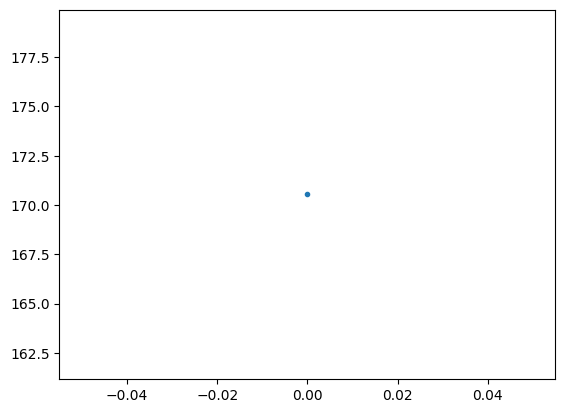

In [ ]:
plt.plot(np.array(table)[:, 3], ".-")

In [ ]:
p_train.mean(), threshold

(0.48700514, 0.4535407364368439)

In [ ]:
import torch
from ml import Net
device = "cuda"
model = Net(7, 32)
model.load_state_dict(torch.load("model.pth"))
model.eval()
# model.set_threshold(-6)
model.to(device)
X_train, X_test, y_train, y_test, profs_train, profs_test, tf_test = get_data(X, y, test_split=1)
p_test = model(torch.tensor(X_test).float().to(device)).squeeze()
# profs_test.sum(), (profs_test*p_test).sum()
p_test

In [ ]:
X_train.shape

In [ ]:
list(model.named_parameters())[0]

In [ ]:
plt.plot(model(torch.tensor(X_test).float().to(device)).squeeze().detach().cpu().numpy())

In [ ]:
threshold

In [ ]:
y_test.sum(), (p_test>threshold).sum(), p_test.shape[0], y_test.shape[0]

In [ ]:
import mplfinance as mpf

ticker = "BTCUSDT"
tf = "H1"
hist_pd, hist = DataParser(
    EasyDict(
        date_start="2008-01-01",
        period=tf,
        ticker=ticker,
        data_type="bitfinex"
        )).load()

for i in ids_test:
    pos = poslist[i]
    if pos.ticker == ticker:
        prediction = model.predict_proba([X[i, :-1]])[0][1]
        if prediction < threshold:
            print(pos.ticker, pos.open_date, prediction)
            d2 = pd.to_datetime(pos.close_date)
            d1 = pd.to_datetime(pos.open_date)
            d0 = d1 - pd.DateOffset(days=3)
            hist2plot = hist_pd.loc[d0:d2]
            fig = mpf.plot(hist2plot, 
                type='candle', 
                block=False)

In [ ]:
prediction